<div class='alert-block alert-info'>
    <br>
    <h1 align="center"><b>  Programming in data science :</b> Final Project </h1>
    <h3 align="center">Earthquake dataset </h3>
    <h5 align="center">BONNELL Hugo - HAMADEH Rayan - BLANCHET Lucas - AFFES Nour - MAARBANI Yasmine - BRUN Pierre-Louis</a></h5>
    <br>
</div>

# Imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from scipy.stats import zscore

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from plotly import express as px

# ARIMA : Library used in a green AI project to forecast, reusing it here
from statsmodels.tsa.arima.model import ARIMA

import dash
from dash import dcc, html
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

# Functions

In [34]:
def import_csv(filePath):
    """
    Function for reading a CSV file

    Input: filePath <string> : The path to the CSV file.

    Returns : data <pd.DataFrame> : The data as a pandas' dataframe.

    """
    return pd.read_csv(filePath)

In [35]:
# Number of rows and columns

def EDA(data):
    """
    This function aims to help explore the dataset
    
    Parameters: data <pandas.DataFrame> : dataset we're studying.

    Returns: None

    Prints: 
        1 - number of columns and rows
        2 - data type in each column
        3 - number of missing data per column
        4 - correlation between variables
    """
    row, col = data.shape
    print("The dataset has : ", row, " rows and ", col ," columns.")
    
    
    print("\n\n--------------------------------\n\n")
    print("Data Information : ")
    print(data.info())
    
    
    print("\n\n--------------------------------\n\n")
    print("Number of null per column:")
    print(data.isna().sum())
    
    
    print("\n\n--------------------------------\n\n")
    print("Correlation matrix:")

    # Compute the correlation matrix 
    data['Location_Name_Encoded'] = LabelEncoder().fit_transform(data['Location Name'])
    corr_matrix = data.drop(columns=['Location Name']).corr(method='pearson')

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
    plt.title("Correlation Matrix (Pearson Method)")
    plt.tight_layout()
    plt.show()

    data.drop(columns=['Location_Name_Encoded'], inplace=True)

    return corr_matrix


In [36]:
def max_magnitude_by_year(data):
    """
    Finds the maximum earthquake magnitude for each year.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing 'Year' and 'Mag' columns.

    Returns:
    pd.DataFrame: A DataFrame showing the maximum magnitude per year.
    """
    result = data.groupby('Year')['Mag'].max().reset_index()
    result.columns = ['Year', 'Max_Magnitude']
    return result

In [37]:
def earthquakes_by_location(data):
    """
    Counts the total number of earthquakes for each location.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing 'Location Name'.

    Returns:
    pd.DataFrame: A summary DataFrame showing the total earthquakes per location.
    """
    result = data['Location Name'].value_counts().reset_index()
    result.columns = ['Location', 'Total_Earthquakes']
    return result

In [38]:
def monthly_distribution(data):
    """
    Extracts the month from 'Mo' column and counts earthquakes per month.

    Parameters:
    data (pd.DataFrame): The dataset containing 'Mo' column.

    Returns:
    pd.DataFrame: A summary of earthquakes by month.
    """
    result = data['Mo'].value_counts().sort_index().reset_index()
    result.columns = ['Month', 'Total_Earthquakes']
    return result

In [39]:
def average_depth_by_magnitude(data):
    """
    Groups earthquakes into magnitude ranges and calculates the average focal depth.

    Parameters:
    data (pd.DataFrame): The dataset containing 'Mag' and 'Focal Depth (km)' columns.

    Returns:
    pd.DataFrame: A DataFrame showing the average focal depth for each magnitude range.
    """
    bins = [0, 4, 6, 8, 10]  # Magnitude ranges
    labels = ['0-4', '4-6', '6-8', '8-10']
    
    # Create magnitude categories
    data['Magnitude_Range'] = pd.cut(data['Mag'], bins=bins, labels=labels)
    
    # Group by magnitude range and calculate the average focal depth
    result = data.groupby('Magnitude_Range')['Focal Depth (km)'].mean().reset_index()
    result.columns = ['Magnitude_Range', 'Avg_Focal_Depth']
    data.drop(columns=['Magnitude_Range'], inplace=True)
    return result

In [40]:
def discretize_magnitude(data):
    """
    Discretizes the earthquake magnitude into categories (Low, Medium, High, Extreme) 
    and plots them with specific colors.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing the 'Mag' column.

    Returns:
    pd.DataFrame: A DataFrame with an additional 'Magnitude_Category' column.
    """
    # Define magnitude bins and labels
    bins = [0, 4, 6, 7, 10]  # Magnitude ranges
    labels = ['Low', 'Medium', 'High', 'Extreme']

    # Discretize 'Mag' into categories
    data['Magnitude_Category'] = pd.cut(data['Mag'], bins=bins, labels=labels, include_lowest=True)

    return data['Magnitude_Category']

In [41]:

def normalize_magnitude(data):
    """
    Standardizes the earthquake magnitude using Z-score normalization.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing the 'Mag' column.

    Returns:
    pd.DataFrame: A DataFrame with an additional column for normalized magnitudes.
    """
    # Copy the data to avoid modifying the original DataFrame
    data_copy = data.copy()

    # Apply Z-score normalization to the 'Mag' column
    data_copy['Mag_Zscore'] = zscore(data_copy['Mag'], nan_policy='omit')

    return data_copy

In [42]:
def detect_earthquake_hotspots(data, eps=2, min_samples=10):
    """
    Detects earthquake hotspots using DBSCAN clustering.

    Parameters:
    data (pd.DataFrame): Earthquake dataset containing 'Latitude' and 'Longitude'.
    eps (float): The maximum distance between two samples for clustering.
    min_samples (int): The number of samples in a cluster.

    Returns:
    None: Displays a scatter plot of earthquake clusters.
    """
    # Step 1: Extract spatial data (latitude and longitude)
    spatial_data = data[['Latitude', 'Longitude']].dropna()

    # Step 2: Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    spatial_data['Cluster'] = dbscan.fit_predict(spatial_data)

    # Step 3: Visualize the clusters
    fig = plt.figure(figsize=(10, 6))
    plt.scatter(spatial_data['Longitude'], spatial_data['Latitude'], 
                c=spatial_data['Cluster'], cmap='rainbow', s=10, alpha=0.7)
    plt.title("Earthquake Hotspots Detected Using DBSCAN")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Cluster")

    # Display cluster information
    print("Number of clusters (excluding noise):", len(set(spatial_data['Cluster'])) - (1 if -1 in spatial_data['Cluster'] else 0))

In [43]:
def generate_earthquake_map(data):
    """
    Generate a scatter mapbox plot for earthquakes based on latitude, longitude, magnitude, and focal depth.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing 'Latitude', 'Longitude', 'Mag', and 'Focal Depth (km)' columns.
    
    Returns:
    plotly.graph_objects.Figure: A Plotly scatter mapbox figure.
    """
    emap = px.scatter_mapbox(
        data[["Latitude", "Longitude", "Mag", "Focal Depth (km)"]].dropna(),
        lat="Latitude",
        lon="Longitude",
        color="Mag",
        size="Focal Depth (km)",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=20,
        zoom=3  # Adjust zoom level for better visibility
    )
    emap.update_layout(mapbox_style="carto-positron")
    emap.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    return emap

In [44]:
def forecast_earthquakes(data, future_years=5):
    """
    Forecasts the number of earthquakes per year using ARIMA.

    Parameters:
    data (pd.DataFrame): Earthquake dataset containing 'Year'.
    future_years (int): Number of future years to forecast.

    Returns:
    pd.DataFrame: Forecasted number of earthquakes.
    """
    # Step 1: Count earthquakes per year
    earthquakes_per_year = data['Year'].dropna().astype(int).value_counts().sort_index()
    earthquakes_series = earthquakes_per_year.reindex(range(earthquakes_per_year.index.min(), 
                                                             earthquakes_per_year.index.max() + 1), 
                                                      fill_value=0)

    # Step 2: Build and fit ARIMA model
    model = ARIMA(earthquakes_series, order=(2, 1, 1))  # ARIMA parameters can be tuned
    model_fit = model.fit()

    # Step 3: Forecast for future years
    forecast = model_fit.forecast(steps=future_years)

    # Combine historical and forecasted data
    future_index = range(earthquakes_series.index.max() + 1, earthquakes_series.index.max() + 1 + future_years)
    forecast_df = pd.DataFrame({'Year': future_index, 'Forecasted_Earthquakes': forecast.values})

    return forecast_df

# Main Program

In [45]:
def main_function():
    """
    Main function that calls and displays all supplementary functions

    Parameters: None

    Returns: None
    """
    # Exploratory data Analysis    
    data = import_csv('earthquakes.csv')
    EDA(data)


    max_magnitude = max_magnitude_by_year(data)
    max_magnitude['Moving_Avg'] = max_magnitude['Max_Magnitude'].rolling(window=20).mean()

    fig1 = go.Figure(go.Scatter(x=max_magnitude['Year'], y=max_magnitude['Moving_Avg'], mode='lines', name="Max Magnitude"))
    fig1.update_layout(title="Average Max Magnitude per year", xaxis_title="Year", yaxis_title="Max Magnitude", xaxis=dict(range=[0, 2020]))
    

    monthly_earthquakes = monthly_distribution(data)
    fig2 = go.Figure(go.Bar(x=monthly_earthquakes['Month'], y=monthly_earthquakes['Total_Earthquakes'], name="Monthly Earthquakes"))
    fig2.update_layout(title="Number of Earthquakes per Month", xaxis_title="Month", yaxis_title="Total Earthquakes")

    
    discretized_data = discretize_magnitude(data)
    discretized_counts = discretized_data.value_counts().sort_index()
    fig3 = go.Figure(go.Bar(x=discretized_counts.index, y=discretized_counts.values, name="Earthquakes Categories"))
    fig3.update_layout(title="Number of Earthquakes per Category", xaxis_title="Category", yaxis_title="Number of Earthquakes")


    normalized_data = normalize_magnitude(data)
    normalized_data_counts = normalized_data["Mag_Zscore"].value_counts().sort_index()
    fig4 = go.Figure(go.Bar(x=normalized_data_counts.index, y=normalized_data_counts.values, name="Normalized Mags"))
    fig4.update_layout(title="Normalized (Zscore) Magnitude", xaxis_title="Magnitude's ZScore", yaxis_title="Count")

    forecasted_earthquakes = forecast_earthquakes(data, future_years=5)
    fig5 = go.Figure(go.Bar(x=forecasted_earthquakes['Year'], y=forecasted_earthquakes['Forecasted_Earthquakes'], name='Normalized Mags'))
    fig5.update_layout(title="Earthquakes ARIMA Forecast", xaxis_title="Year", yaxis_title="Forecasted Earthquakes", yaxis=dict(range=[40, 55]))

    emap = generate_earthquake_map(data)

    dashboard_creator(fig1, fig2, fig3, fig4, fig5, emap)

    pass


def dashboard_creator(fig1, fig2, fig3, fig4, fig5, emap):
    """
    Function to create dashboard

    Parameters: figures previously generated

    Returns: None
    """
    # Initialize the Dash app
    app = dash.Dash(__name__)

    # Dataset and Team Info
    dataset_name = "Earthquake Dataset"
    team_members = ["BONNELL Hugo", "HAMADEH Rayan", "BLANCHET Lucas", "AFFES Nour", "MAARBANI Yasmine", "BRUN Pierre-Louis"]

    # Layout for Dash App
    app.layout = html.Div([
        # Header Section
        html.Div([
            html.H1("Earthquake Metrics Dashboard"),
            html.H3(f"Dataset: {dataset_name}"),
            html.H4(f"Team Members: {', '.join(team_members)}")
        ], style={'textAlign': 'center', 'marginBottom': '20px'}),
        
        # Metric Visualizations
        html.Div([
            html.Div([
                dcc.Graph(figure=fig1)
            ], className='six columns'),
            html.Div([
                dcc.Graph(figure=fig2)
            ], className='six columns'),
        ], className='row'),
        
        html.Div([
            html.Div([
                dcc.Graph(figure=fig3)
            ], className='six columns'),
            html.Div([
                dcc.Graph(figure=fig4)
            ], className='six columns'),
        ], className='row'),

        html.Div([
            html.Div([
                dcc.Graph(figure=fig5)
            ], className='six columns')
        ], className='row'),

        html.Div([
        dcc.Graph(
            id='earthquake-map',
            figure=emap
        )], style={'marginTop': '20px'})

    ], style={'margin': '20px'})

    app.run_server(debug=True)

    pass 

# Running the app (Dashboard at the end of this section)

The dataset has :  4424  rows and  38  columns.


--------------------------------


Data Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                4424 non-null   float64
 1   Mo                                  4330 non-null   float64
 2   Dy                                  4280 non-null   float64
 3   Hr                                  3665 non-null   float64
 4   Mn                                  3581 non-null   float64
 5   Sec                                 3437 non-null   float64
 6   Tsu                                 1390 non-null   float64
 7   Vol                                 36 non-null     float64
 8   Location Name                       4423 non-null   object 
 9   Latitude                            4424 non-null   float64
 10  Lon

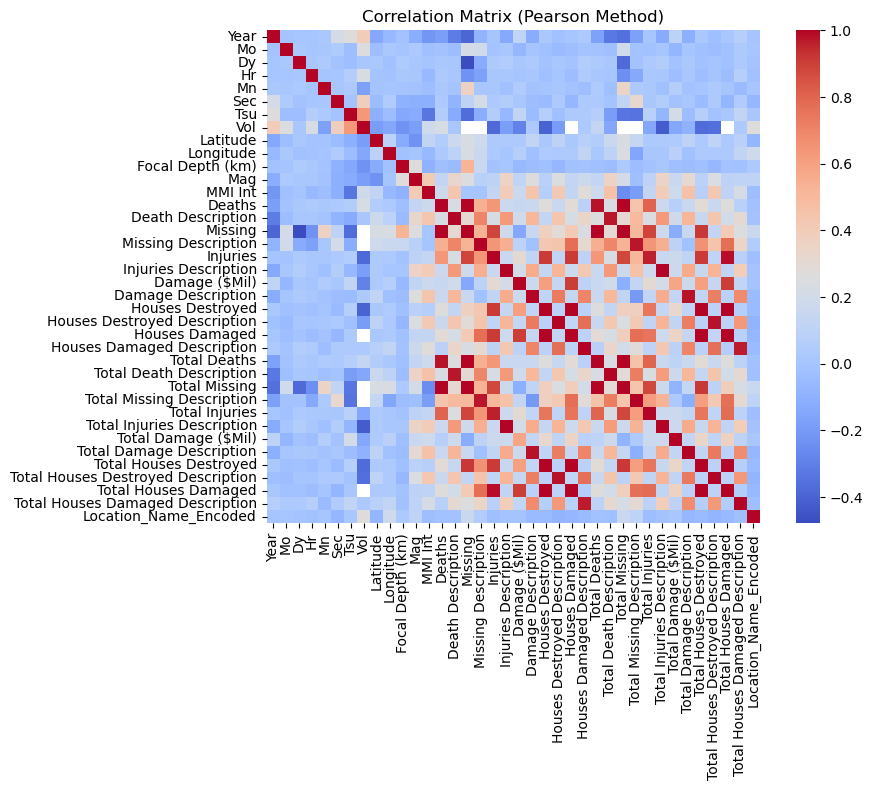

In [46]:
# Run the app
if __name__ == "__main__":
    main_function()

# Analysis

## Exploratory Data Analysis

So from the EDA function we can see that:
- Our data set is of shape 4424x38.

- All of our columns are of time float except for the 'Location Name' column which contains an object (string) (which we encoded into an integer just for the correlation matrix so that we can study it as well).

- We have a significant issue regarding the null values in our columns which might pause problems later on.

- Correlation Matrix:
  - Recap about what correlation matrix helps with:
    A correlation matrix shows the pairwise relationships (correlations) between numerical variables in a dataset.

    Values range from -1 to 1:
        +1: Perfect positive correlation (both variables increase together).
        -1: Perfect negative correlation (one increases while the other decreases).
        0: No correlation (the variables are independent)
        
  - Key observations:
    - Variables like **Deaths**, **Total Deaths**, and **Death Description** are highly correlated, which makes perfect sense.
    - **Houses Destroyed** and **Total Houses Distroyed** are also highly correlated.

    - Negative correlation present between **Focal Depth** and **Damage** which helps us understand that if the focal depth increases, the damage decreases due to deeper quakes having less impact on the surface.

    - **Latitude** and **Temperature** are negatively correlated as well, which means higher latitudes (locations closer to the poles) are associated with lower temperatures.


### max_maggnitude_by_year
So what this function does is plot a line graph of the maximum magnitude per year.

We were obliged to apply a moving average (rolling window of 20) so that our graph is actually readable.

Observing the graph, there is a noticeable upward trend in the maximum earthquake magntiudes over time. This trend is especially noticeable about 1500 and onwards, reaching an alltime high in our last year recorded in our dataset at hand (2020).

This could indicate one of two results:
- Increase in the severity of earthquakes with time.
- Improvements in seismic measurement technologies and methods, allowing for more frequent and accurate earthquake recordings, which is apparent even by how smooth the graph is in early years, where not nearly as much data was recorded as recent years.


## Indicators analysis

### earthquakes_by_location
This function shows us the top 20 locations in terms of earthquake frequency regardless of earthquake intensity or magnitude. What's obvious here is that China is encountering a lot of earthquakes with Yunnan Province being the most eathquake-prone location in all our dataset.

### monthly_distribution
Here, we display the frequency of earthquakes per month with month 0 being January and 11 being December.

The bar chart shows a consistent distribution of earthquake occurences, with monthly counts ranging between 300 and 380. This indicates that earthquake activity doesn't exhibit a clear seasonal pattern, suggesting the need for year-round preparation and expectation of earthquakes.

### average_depth_by_magnitude
This function groups earthquakes into 4 bins according to magnitude range and shows the average focal depth for each magnitude range.

As the correlation matrix showed us, we can see a negative correlation between focal length and earthquake magnitude indicating that as the focal depth decreases, the magnitude increases

### discretize_magnitude
In discretize_magnitude, we create bins, almost like what we did in the above function, and compare the count of each category of earthquake.

What we could observe was that:
- The count of earthquake is significantly higher for medium, high, and extreme categories, and a significantly low for the "low category".
- This distribution indicates that while low magnitude earthquakes are rare in this dataset, medium to extremely powerful earthquakes occur more frequently which is not typical.
- This is due to the fact that our dataset only focuses on important (high magnitude) earthquakes.

### normalize_magnitude
Z-Score Normalization: the magnitude data is normalized using Z-score method where we adjust the values to have a mean of 0 and a standard deviation of 1, transforming each value to represent its distance from the mean in terms of standard deviations.

Identifying Extreme Events: eathquakes with a Z-score above 2 are considered extreme.

The histogram displays a bell-shaped curve centered around zero, which is typical for Z-score normalized data. The data skews slightly to the right (positive side) indicating a few extreme positive occurences (higher magnitude extreme earthquakes).


## Geodata Analysis

The graphs show earthquake hotspots around the globe. The graphs identify specific regions with a high density of earthquakes, such as: 
- Pacific Ring of Fire (pacific coasts of Asia and the Americas)
- Mid-Atlantic Ridge
- South-East Asia Régions. 
  
They also show sparce earthquake regions that are either outliers or less prone to earthquake activity.